## 46-886

## Regularization: Ridge and Lasso Regression

### Application: Predicting Diabetes Disease Progression
 

Amr Farahat

CMU / Tepper

2023-04-10

---

## 0. Setting up

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import statsmodels.api as sm
from graphviz import Source
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

In [3]:
# new imports
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV

In [4]:
pd.options.display.max_columns = None

In [5]:
def OSR2(y_actual,y_pred,baseline):
    residuals = y_actual - y_pred
    SSR = np.sum((residuals)^2)
    SST = np.sum((y_actual - baseline)^2)
    R2 = 1 - SSR / SST
    return(R2) 

## 1. Reading in data

Original data can be found here: 
https://hastie.su.domains/StatLearnSparsity_files/DATA/diabetes.html

We will use a standardized version that includes quadratic and interaction terms. 

The data is standardized as follows:
1. Standardizing the 10 main indep vars
2. Creating quadratic+interaction terms
3. Re-standardizing the quadratic/interaction terms

In [6]:
df = pd.read_csv("df.csv")

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442 entries, 0 to 441
Data columns (total 66 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   all.obs  442 non-null    int64  
 1   y        442 non-null    int64  
 2   age      442 non-null    float64
 3   sex      442 non-null    float64
 4   bmi      442 non-null    float64
 5   map      442 non-null    float64
 6   tc       442 non-null    float64
 7   ldl      442 non-null    float64
 8   hdl      442 non-null    float64
 9   tch      442 non-null    float64
 10  ltg      442 non-null    float64
 11  glu      442 non-null    float64
 12  age^2    442 non-null    float64
 13  bmi^2    442 non-null    float64
 14  map^2    442 non-null    float64
 15  tc^2     442 non-null    float64
 16  ldl^2    442 non-null    float64
 17  hdl^2    442 non-null    float64
 18  tch^2    442 non-null    float64
 19  ltg^2    442 non-null    float64
 20  glu^2    442 non-null    float64
 21  age:sex  442 non

The dataframe has been split in a 70% train sample and a 30% test sample in the files <df_train.csv> and <df_test.csv>

In [8]:
df_train = pd.read_csv("df_train.csv")
df_test = pd.read_csv("df_test.csv")

In [9]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309 entries, 0 to 308
Data columns (total 66 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   train.obs  309 non-null    int64  
 1   y          309 non-null    int64  
 2   age        309 non-null    float64
 3   sex        309 non-null    float64
 4   bmi        309 non-null    float64
 5   map        309 non-null    float64
 6   tc         309 non-null    float64
 7   ldl        309 non-null    float64
 8   hdl        309 non-null    float64
 9   tch        309 non-null    float64
 10  ltg        309 non-null    float64
 11  glu        309 non-null    float64
 12  age^2      309 non-null    float64
 13  bmi^2      309 non-null    float64
 14  map^2      309 non-null    float64
 15  tc^2       309 non-null    float64
 16  ldl^2      309 non-null    float64
 17  hdl^2      309 non-null    float64
 18  tch^2      309 non-null    float64
 19  ltg^2      309 non-null    float64
 20  glu^2     

In [10]:
y_train = df_train["y"]
X_train = df_train.drop(["y","train.obs"], axis=1)
y_test = df_test["y"]
X_test = df_test.drop(["y","test.obs"], axis=1)

In [11]:
baseline = np.mean(y_train)

## 3. Some (Un-regularized) Linear Regression Models

I'll ignore multi-collinearity in the interest of time,
(Note: In Ridge and LASSO regression below, we don't normally check for multi-collinearity)

#### M0: All 64 variables

In [12]:
lr_mod0 = LinearRegression()
lr_mod0.fit(X_train, y_train)

LinearRegression()

In [13]:
print("Linear Regression train R2: ", lr_mod0.score(X_train, y_train))
print("Linear Regression test R2: ", lr_mod0.score(X_test, y_test))

Linear Regression train R2:  0.6307558171804573
Linear Regression test R2:  0.33911687167391835


In [14]:
y_pred = lr_mod0.predict(X_train)

#### M2: Only the 6 serum variables

In [15]:
mod2_vars = ["tc","ldl","hdl","tch","ltg","glu"]

In [16]:
X_train_mod2 = X_train[mod2_vars]
X_test_mod2 = X_test[mod2_vars]

In [17]:
lr_mod2 = LinearRegression()
lr_mod2.fit(X_train_mod2, y_train)

LinearRegression()

In [18]:
print("Linear Regression train R2: ", lr_mod2.score(X_train_mod2, y_train))
print("Linear Regression test R2: ", lr_mod2.score(X_test_mod2, y_test))

Linear Regression train R2:  0.36663416413717786
Linear Regression test R2:  0.3873010981999875


## 4. Ridge Regression

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html

In [19]:
ridge_mod = Ridge(alpha=1, solver="cholesky")

In [20]:
ridge_mod.fit(X_train, y_train)

Ridge(alpha=1, solver='cholesky')

Note: Can use the predict() and get_params() methods

In [21]:
print("Ridge Regression train R2: ", ridge_mod.score(X_train, y_train))
print("Ridge Regression test R2: ", ridge_mod.score(X_test, y_test))

Ridge Regression train R2:  0.49993800389441023
Ridge Regression test R2:  0.3863128498481291


#### With CV

In [22]:
alphas=np.logspace(-1, 2, 4)

In [23]:
ridge_mod_cv = RidgeCV(alphas=alphas, store_cv_values=True)

In [24]:
ridge_mod_cv.fit(X_train, y_train)

RidgeCV(alphas=array([  0.1,   1. ,  10. , 100. ]), store_cv_values=True)

In [25]:
ridge_mod_cv.alpha_

0.1

In [26]:
#ridge_mod_cv.cv_values_

In [27]:
print("Ridge Regression with CV train R2: ", ridge_mod_cv.score(X_train, y_train))
print("Ridge Regression with CV test R2: ", ridge_mod_cv.score(X_test, y_test))

Ridge Regression with CV train R2:  0.6015142137574825
Ridge Regression with CV test R2:  0.42276773019552205


#### Compute and Display Paths

In [28]:
alphas=np.logspace(-5, +10, 16, base=np.e)

In [29]:
coefs = []
for a in alphas:
    ridge = Ridge(alpha=a, solver="cholesky")
    ridge.fit(X_train, y_train)
    coefs.append(ridge.coef_)

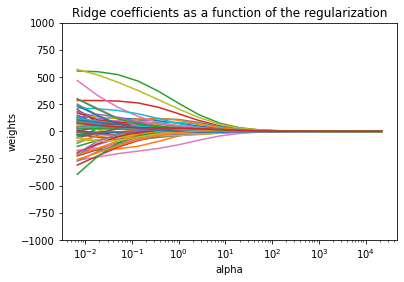

In [30]:
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale("log")
plt.ylim(-1000, +1000)
plt.xlabel("alpha")
plt.ylabel("weights")
plt.title("Ridge coefficients as a function of the regularization")
#plt.axis("tight")
plt.show()

Perhaps a better graphing code:
https://scikit-learn.org/stable/auto_examples/linear_model/plot_lasso_coordinate_descent_path.html#sphx-glr-auto-examples-linear-model-plot-lasso-coordinate-descent-path-py

## 5. LASSO Regression

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html

In [31]:
lasso_mod = Lasso(alpha=1)

In [32]:
lasso_mod.fit(X_train, y_train)

Lasso(alpha=1)

Note: Can use the predict() and get_params() methods

In [33]:
print("LASSO Regression train R2: ", lasso_mod.score(X_train, y_train))
print("LASSO Regression test R2: ", lasso_mod.score(X_test, y_test))

LASSO Regression train R2:  0.38907707594305974
LASSO Regression test R2:  0.31364192994133555


#### With CV

In [34]:
alphas=np.logspace(-1, 2, 4)

In [35]:
lasso_mod_cv = LassoCV(alphas=alphas)

In [36]:
lasso_mod_cv.fit(X_train, y_train)

LassoCV(alphas=array([  0.1,   1. ,  10. , 100. ]))

In [37]:
lasso_mod_cv.alpha_

0.1

In [38]:
print("LASSO Regression with CV train R2: ", lasso_mod_cv.score(X_train, y_train))
print("LASSO Regression with CV test R2: ", lasso_mod_cv.score(X_test, y_test))

LASSO Regression with CV train R2:  0.5730385944532028
LASSO Regression with CV test R2:  0.4392288550837622


#### Compute and Display Paths

In [39]:
alphas=np.logspace(-5, +5, 11, base=np.e)

In [40]:
coefs = []
for a in alphas:
    lasso = Lasso(alpha=a)
    lasso.fit(X_train, y_train)
    coefs.append(lasso.coef_)

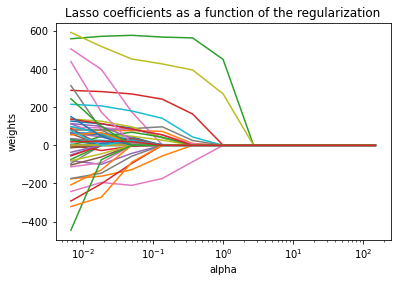

In [41]:
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale("log")
plt.ylim(-1000, +1000)
plt.xlabel("alpha")
plt.ylabel("weights")
plt.title("Lasso coefficients as a function of the regularization")
plt.axis("tight")
plt.show()

## 6. ElasticNet Regression

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html

In [42]:
elasticNet_mod = ElasticNet(alpha=0.1, l1_ratio=0.5)
elasticNet_mod.fit(X_train, y_train)

ElasticNet(alpha=0.1)

In [43]:
print("ElasticNet Regression train R2: ", elasticNet_mod.score(X_train, y_train))
print("ElasticNet Regression test R2: ", elasticNet_mod.score(X_test, y_test))

ElasticNet Regression train R2:  0.1375354305893971
ElasticNet Regression test R2:  0.10966958271575922


#### With CV

In [44]:
elasticNet_mod_cv = ElasticNetCV(alphas=alphas, l1_ratio=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], max_iter=1000)

In [45]:
elasticNet_mod_cv.fit(X_train, y_train)

ElasticNetCV(alphas=array([6.73794700e-03, 1.83156389e-02, 4.97870684e-02, 1.35335283e-01,
       3.67879441e-01, 1.00000000e+00, 2.71828183e+00, 7.38905610e+00,
       2.00855369e+01, 5.45981500e+01, 1.48413159e+02]),
             l1_ratio=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

In [46]:
print("ElasticNet Regression with CV train R2: ", elasticNet_mod_cv.score(X_train, y_train))
print("ElasticNet Regression with CV test R2: ", elasticNet_mod_cv.score(X_test, y_test))

ElasticNet Regression with CV train R2:  0.5835511676117848
ElasticNet Regression with CV test R2:  0.42808132401553


## END